## Q3 : Add control variate (second order polynomial) to implement Zero variance Markov chain Monte Carlo Method (ZV-MCMC) with lasso selection

We should replicate the procedure of question 2 but with a polynomial of degree 2. The problem is that we will have a lot of control variate because the gradient is of dimension 3 and the hesian of dimension 3*3. So we have to implement a lasso algorithm to choose the best control variate. From the best control variate, we will be able to define a new function which will have less variance than in the simple algorithm but it will have the same average.

Given the difficulties we had in implementing the gradient in question 2, we decided to choose a simple polynomial function of degree 2 to be able to apply a lasso regression and get results in the metropolis algorythm even if the new function defined will not be optimal. 

### Libraries set up

In [199]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import os
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

In [2]:
os.chdir("/Users/ludovic/Desktop/ENSAE/S2/MC/Garch_ZV_MCMC") #set up the location of the project 

### Simulation of data following a GARCH(1,1) process

We take the simulated garch process of question 1 (with parameters 0.3, 0.2, 0.5): 

In [3]:
r_garch = pd.read_csv("r_garch.csv")
r_garch = np.array(r_garch["0"])

## Control variate estimation

For the step 1 we take the same data than in question 2 : 

In [259]:
zvmcmc_results_1step = pd.read_csv('mcmc_results.csv')

We transform our 3 lists to be usable in our folowing function :

In [260]:
B=4000
X_stack = np.vstack([zvmcmc_results_1step['omega'][B:], zvmcmc_results_1step['alpha'][B:], zvmcmc_results_1step['beta'][B:]])

In [261]:
X_stack = X_stack.T

We try to estimate g through a polynomial of degree 2 to create a new normalized function, $f$ :

$$f(x) = g(x) - a^tx -b^tx^2$$

with $[a,b]$ equal to the vector of coefficient of an OLS regression of $g$ on $x$ and $x^2$. $f$ is the predicted residuals of this regression. 

This renormalization allows the algorythm to create less variance because the variance of the new function decreases relatively to the first function.

We calculate the density on each combination of simulated parameters of step 1 (we redefine the density function only as a reminder because it is already defined above), it will be our dependant variable in the regresssion:

In [262]:
def g_i(r, h):
    return -0.5 * np.log(h) - 0.5 * (r**2 / h) # Normal law because r_{t}|F_t-1 follow N(0,h_t)

def g(x , data, h_initial): 
    LL = g_i(data[0],h_initial) # density is initialized with our first simulated data
    h_t = h_initial
    
    for i in range(1, len(data)):
        h = h_t
        h_t = x[0] + x[1] * data[i-1]**2 + x[2] * h
        LL += g_i(data[i],h_t) #iteration on the Garch process

    return LL

In [263]:
def optimize_h(data):
    fun = lambda h: -g_i(data[0], h) # function to minimize
    h_init = 1 # initial value for h
    result = minimize(fun, h_init, method='BFGS') # grandient descent method

    h_optimal = result.x[0] #result
    return h_optimal

h_initial = optimize_h(r_garch)

In [264]:
y = list(map(lambda x: g(x, data=r_garch, h_initial=h_initial), X_stack))

We our control variates, i.e $x$ and $x**2$:

In [265]:
cv1 = zvmcmc_results_1step['omega'][B:]
cv2 = zvmcmc_results_1step['alpha'][B:]
cv3 = zvmcmc_results_1step['beta'][B:]
cv1_square = np.square(zvmcmc_results_1step['omega'][B:])
cv2_square = np.square(zvmcmc_results_1step['alpha'][B:])
cv3_square = np.square(zvmcmc_results_1step['beta'][B:])

We plot coefficients value wrt to lambda to be able to choose an appropriate lamba in our final specification choice:

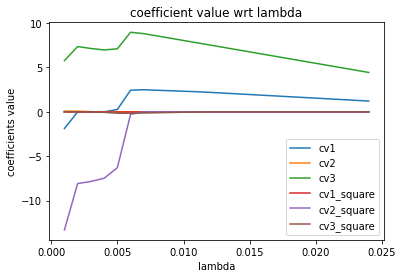

In [272]:
X = np.vstack([cv1,cv2,cv3,cv1_square,cv2_square,cv3_square])
X = StandardScaler().fit_transform(X) #normalisation of variable required in lasso
X = X.T

#a= StandardScaler().fit_transform(np.array(y).reshape(-1, 1))

# list for lambda values
lambdas = np.arange(0.001, 0.025, 0.001)

# Initialisation des coefficients
coefs = []

# Entraînement du modèle Lasso pour chaque valeur de alpha
for a in lambdas:
    lasso_model = Lasso(alpha=a, max_iter=10000)
    lasso_model.fit(X, y)
    coefs.append(lasso_model.coef_)

# Affichage des coefficients en fonction de lambda
plt.figure()
plt.plot(lambdas, coefs)
plt.xlabel('lambda')
plt.ylabel('coefficients value')
plt.title('coefficient value wrt lambda')
plt.legend(['cv1', 'cv2', 'cv3', 'cv1_square', 'cv2_square', 'cv3_square'])
plt.show()

We choose lambda to keep at least the third best covariates :

In [268]:
X = np.vstack([cv1,cv2,cv3,cv1_square,cv2_square,cv3_square])
X = StandardScaler().fit_transform(X) #normalisation of variable required in lasso
X = X.T
#X = sm.add_constant(X)

# Lasso fitting
lasso_model = Lasso(alpha=0.005, max_iter=10000)
lasso_model.fit(X, y)
print(lasso_model.coef_)

[ 0.26834921  0.          7.09688223 -0.         -6.2835641  -0.15259025]


We define a function to predict with a combination of 3 parameters based on our lasso regression:

In [273]:
def predict_y(cv1_i, cv2_i, cv3_i):
    # square computing
    cv1_sq_i = cv1_i ** 2
    cv2_sq_i = cv2_i ** 2
    cv3_sq_i = cv3_i ** 2
    
    #predictor
    x = np.hstack([ cv1_i, cv2_i, cv3_i,cv1_sq_i,cv2_sq_i,cv3_sq_i])
    
    # y prediction according to lasso estimates
    y_pred = lasso_model.predict([x])
    
    return y_pred[0]

Thanks to the estimated coefficients we can define $f$, our new function with a supposed reduced variance:

In [275]:
def f(x , data, h_initial):
    
    f =   g(x , data, h_initial) - predict_y(x[0],x[1],x[2])

    return f

## ZV-MCMC

The last step consists in running the algorithm again but with the new function f to calculate the density and accept or not the proposed combination. 

In [276]:
M = 2000 # size of the desired sample
#X = np.random.rand(3) # Random starting point for the Markov chain (dim=3)
X= [0.31, 0.19, 0.49] # Deterministic starting point for the Markov chain (dim=3)
sigma = 0.009  # volatility for the proposal function (fixed by looking for an acceptance rate between 0.3 and 0.6)
x1list = []  # for keeping track of omega values
x2list = [] # for keeping track of alpha values
x3list = [] # for keeping track of beta values
numaccept = 0 # counts the number of acceptance in the accept/rejct algorithm
i = 0 #initialization of i, the total number of iteration 
h_initial=optimize_h(r_garch) #initial h for the density computation

Algorythm :

In [277]:
while numaccept < M:
    Y = X + np.random.normal(loc=0, scale=sigma, size=3)  # Proposal move with a normal distribution (dim=3 because 3 parameters)
    U = np.log(np.random.rand(1)) # Random draw in a uniform distribution for accept/reject
    if np.all(Y > 0): # Reject all samples where any parameter is negative (truncated normal distribution)
        alpha = f(Y, data = r_garch, h_initial=h_initial) - f(X, data = r_garch, h_initial=h_initial)  # Difference between current and previous density accept/reject
        if U < alpha:  # Reject if the ratio of densities is lower than a draw in a uniform distribution
            X = Y  # Accept proposal
            numaccept += 1 # Counts the number of acceptance in the accept/reject algorithm
    
            x1list.append(X[0])   # Add the values to the lists of omega
            x2list.append(X[1])   # Add the values to the lists of alpha
            x3list.append(X[2])   # Add the values to the lists of beta
    
    # Output progress report (can be long)
    i += 1 # Counts the number of total iteration 
    if (i % 1000) == 0:
        print(" ...", i)

 ... 1000
 ... 2000
 ... 3000


#### Exploitation of the results

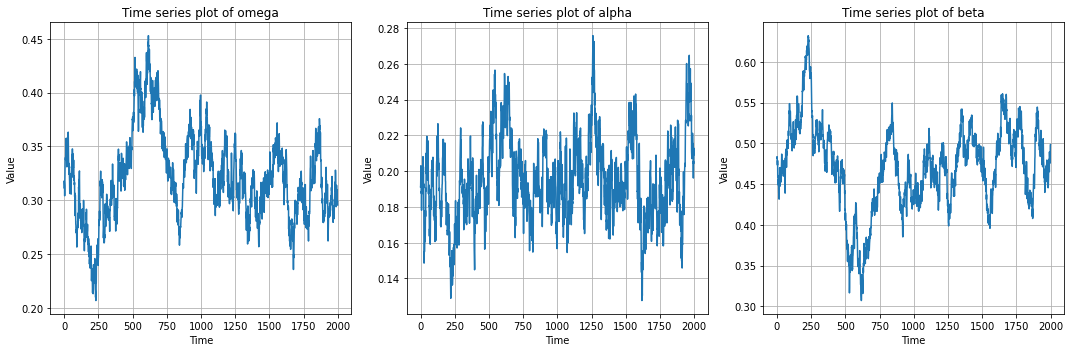

In [278]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot time series graphs for x1list, x2list and x3list
axs[0].plot(x1list)
axs[0].set_title("Time series plot of omega")
axs[1].plot(x2list)
axs[1].set_title("Time series plot of alpha")
axs[2].plot(x3list)
axs[2].set_title("Time series plot of beta")

# Title and grid settings for time series charts
for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)

# Display time series graphs side by side
plt.tight_layout()
plt.show()

In [279]:
B = 50  # amount of burn-in

We plot the density of the sample for each parameters :

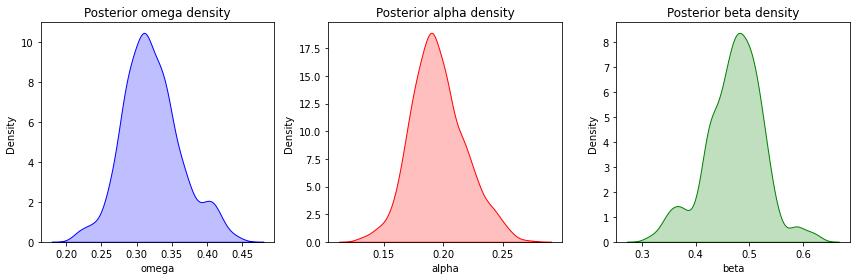

In [280]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# plot omega
sns.kdeplot(x1list[(B):(len(x1list))], fill=True, color='b', ax=axes[0])
axes[0].set_xlabel('omega')
axes[0].set_ylabel('Density ')
axes[0].set_title('Posterior omega density')

# plot alpha
sns.kdeplot(x2list[(B):(len(x2list))], fill=True, color='r', ax=axes[1])
axes[1].set_xlabel('alpha')
axes[1].set_ylabel('Density ')
axes[1].set_title('Posterior alpha density')

# plot beta
sns.kdeplot(x3list[(B):(len(x3list))], fill=True, color='g', ax=axes[2])
axes[2].set_xlabel('beta')
axes[2].set_ylabel('Density ')
axes[2].set_title('Posterior beta density')

# space between subgraphs
plt.tight_layout()

# Display
plt.show()

We can now determine the parameters by averaging the sample over the values that do not belong to the burn in :

In [281]:
print("ran Metropolis algorithm for", M, "iterations, with burn-in", B)
print("acceptance rate =", numaccept/i)
u = np.mean(x1list[B:len(x1list)])
print("mean of x1 is about", u)
v = np.mean(x2list[B:len(x2list)])
print("mean of x2 is about", v)
w = np.mean(x3list[B:len(x3list)])
print("mean of x3 is about", w)

ran Metropolis algorithm for 2000 iterations, with burn-in 50
acceptance rate = 0.5775339301183945
mean of x1 is about 0.32138325679619467
mean of x2 is about 0.19548928907185434
mean of x3 is about 0.4719461688802537


We store the 3 samples to compare with Q1 in the following box plot : 

In [282]:
zvmcmc_results_P2 = pd.DataFrame({'omega': x1list, 'alpha': x2list, 'beta': x3list})
zvmcmc_results_P2.to_csv('zvmcmc_results_P2.csv', index=False)

### Comparaison avec Q1

In [283]:
mcmc_results = pd.read_csv("mcmc_results.csv")

We can see a quasi identic mean (it would be better with more iteration). Variance does not really decreases with our method.

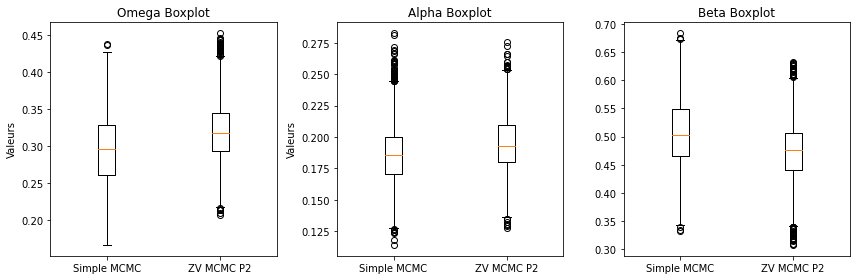

In [284]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Omega box-plot
axes[0].boxplot([mcmc_results['omega'][B:], zvmcmc_results_P2['omega'][B:]])
axes[0].set_xticklabels(['Simple MCMC', 'ZV MCMC P2'])
axes[0].set_ylabel('Valeurs')
axes[0].set_title('Omega Boxplot')

# Alpha box-plot
axes[1].boxplot([mcmc_results['alpha'][B:], zvmcmc_results_P2['alpha'][B:]])
axes[1].set_xticklabels(['Simple MCMC', 'ZV MCMC P2'])
axes[1].set_ylabel('Valeurs')
axes[1].set_title('Alpha Boxplot')

# Beta box-plot
axes[2].boxplot([mcmc_results['beta'][B:], zvmcmc_results_P2['beta'][B:]])
axes[2].set_xticklabels(['Simple MCMC', 'ZV MCMC P2'])
axes[2].set_title('Beta Boxplot')

# space between subplots
fig.tight_layout()

# Display
plt.show()

## Q4 : Dependance issue in regression

OLS regression relies in part on the assumption that the sample is independent and identically distributed. However, our sample is built from 3 Markov chains so the observations are necessarily dependent. To overcome this problem we would have to run the algorithm of step 1, i.e. question 1, a large number of times. Then, from the autocorrelation function, decide on the distance from which the observations are no longer correlated. This will reduce the autocorrelation problems in an efficient way.

In [287]:
x1list_ind = x1list[::100] #one value out of 100
x2list_ind = x2list[::100] 
x3list_ind = x3list[::100] 

The lists created here are too short but with a more powerful computer, and thus a larger number of iterations in step 1, we could re-run the OLS and LASSO regression and compare the results.